In [ ]:
!pip install yahoofinancials mpld3 pyit2fls

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from yahoofinancials import YahooFinancials
%matplotlib inline
import mpld3
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from pyit2fls import IT2FS_Gaussian_UncertStd, crisp, IT2FS_plot

mpld3.enable_notebook()

In [ ]:
end_date = datetime.today()
start_date = end_date - timedelta(days=15 * 365)
ticker = 'A17U.SI'
df = yf.download(ticker, start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,A17U.SI,A17U.SI,A17U.SI,A17U.SI,A17U.SI,A17U.SI
Date,,,,,,
2009-11-20 00:00:00+00:00,0.764593,1.806241,1.816005,1.776951,1.786714,3940198
2009-11-23 00:00:00+00:00,0.776992,1.835532,1.855058,1.806241,1.816005,4672519
2009-11-24 00:00:00+00:00,0.797656,1.884349,1.894112,1.845295,1.845295,10950002
2009-11-25 00:00:00+00:00,0.785257,1.855058,1.874585,1.845295,1.864822,6783450
2009-11-26 00:00:00+00:00,0.781125,1.845295,1.884349,1.835532,1.884349,1605986


In [ ]:
##LSTM - Benchmark Model

In [ ]:
df['Price_Diff'] = df['Close'].diff()
df['Volatility'] = df['Close'].rolling(window=10).std()

df['LSTM_Fast_SMA'] = df['Close'].rolling(window = 20, min_periods = 1).mean()
df['LSTM_Slow_SMA'] = df['Close'].rolling(window = 100, min_periods = 1).mean()

df['Fast_SMA'] = df['Close'].rolling(window = 20, min_periods = 1).mean()
df['Slow_SMA'] = df['Close'].rolling(window = 100, min_periods = 1).mean()

# Drop any rows with NaN values (resulting from the rolling window and differencing)
df.dropna(inplace=True)

# 2. Prepare the Dataset with Selected Features
features = df[['Close', 'LSTM_Fast_SMA', 'LSTM_Slow_SMA', 'Volume', 'Price_Diff', 'Volatility']]

# Normalize the data for stability
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [ ]:
# 3. Create Sequences for LSTM Input
sequence_length = 30  # Use the last 30 days of data to predict the next day
X, y = [], []
for i in range(sequence_length, len(scaled_features)):
    X.append(scaled_features[i-sequence_length:i])  # Last 30 days of features
    y.append(scaled_features[i, 0])  # Next day's closing price as the target

# Convert lists to numpy arrays
X, y = np.array(X), np.array(y)

# 4. Split the Data into Training and Testing Sets
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# 5. Define the LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)  # Output layer with one unit (predicting the closing price)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0336 - val_loss: 0.0021
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.5437e-04 - val_loss: 8.7951e-04
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.7196e-04 - val_loss: 7.6045e-04
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3932e-04 - val_loss: 6.7716e-04
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4646e-04 - val_loss: 5.3522e-04
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.1190e-04 - val_loss: 5.6619e-04
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9575e-04 - val_loss: 5.3104e-04
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.5225e-04 - val_loss: 3.9281e-04
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3455e-04 - val_loss

In [ ]:
#Fuzzy LSTM

#df[['Price_Diff', 'Close', 'LSTM_Fast_SMA', 'LSTM_Slow_SMA']]
features_n_clusters = [5, 5, 5, 3, 5, 3]

def cluster_features(features, features_n_clusters): #Get cluster centers, means and sigmas for each features given the number of clusters.

  cluster_centers = []
  cluster_means = []
  cluster_sigmas = []

  for i in range(scaled_features.shape[1]):

    n_clusters = features_n_clusters[i]
    feature_datas = scaled_features[:,i].reshape(-1, 1)

    kmeans = KMeans(n_clusters, random_state=42)
    kmeans.fit(feature_datas)

    centers = kmeans.cluster_centers_.flatten().tolist()
    labels = kmeans.labels_ #Calculate means and sigmas for each cluster

    means = []
    sigmas = []

    for i in range(n_clusters):
      cluster_points = feature_datas[labels == i]
      cluster_mean = np.mean(cluster_points)
      cluster_sigma = np.std(cluster_points)

      means.append(cluster_mean)
      sigmas.append(cluster_sigma)

    sorted_cluster_features = sorted(zip(centers, means, sigmas), key=lambda x: x[0])
    centers, means, sigmas = map(list, zip(*sorted_cluster_features))


    cluster_centers.append(centers)
    cluster_means.append(means)
    cluster_sigmas.append(sigmas)


  return cluster_centers, cluster_means, cluster_sigmas


def generate_it2fmf(cluster_means, cluster_sigmas):

  num_features = len(cluster_means)
  it2fmf = []
  for i in range(num_features):
    feature_cluster_means = cluster_means[i]
    feature_cluster_sigmas = cluster_sigmas[i]
    feature_fmf_list = []

    for j in range(len(feature_cluster_means)):
      cluster_mean = feature_cluster_means[j]
      cluster_sigma = feature_cluster_sigmas[j]

      fmf = IT2FS_Gaussian_UncertStd((0, 1), [cluster_mean, cluster_sigma, cluster_sigma/2, 1.])
      feature_fmf_list.append(fmf)
    it2fmf.append(feature_fmf_list)
  return it2fmf


cluster_centers, cluster_means, cluster_sigmas = cluster_features(scaled_features, features_n_clusters)
it2fmf = generate_it2fmf(cluster_means, cluster_sigmas)

In [ ]:
domain = (0, 1)  # Input domain range
mean = 0.5       # Mean of the Gaussian
std_low = 0.1    # Standard deviation for the lower membership function (LMF)
std_high = 0.2   # Standard deviation for the upper membership function (UMF)

# Create an IT2FS Gaussian set
it2fs = IT2FS_Gaussian_UncertStd((0, 1), [mean, std_high, std_low, 1.])
x=0.1
# Get the UMF
umf_value = it2fs.umf(x, it2fs.umf_params)  # Pass UMF parameters
lmf_value = it2fs.lmf(x, it2fs.lmf_params)   # Pass LMF parameters

print(umf_value, lmf_value)
# Print the results


0.2780373004531941 0.02856550078455038


In [ ]:
class FuzzyLayer(tf.keras.layers.Layer):
    def __init__(self, it2fmf):
        """
        Custom Fuzzy Layer.
        Parameters:
        - it2fmf: List of fuzzy membership functions for each feature.
        """
        super(FuzzyLayer, self).__init__()
        self.it2fmf = it2fmf  # Precomputed fuzzy membership functions
        self.fmf_count = 0
        for feature_fmf_list in it2fmf:
            self.fmf_count += len(feature_fmf_list)

    def call(self, inputs):
        """
        Compute fuzzy membership degrees for the input features.
        Parameters:
        - inputs: Input tensor of shape (batch_size, num_features).
        Returns:
        - fuzzified_inputs: Tensor of shape (batch_size, num_features, num_memberships).
        """
        feature_membership_values = []
        for i, feature_fmf_list in enumerate(self.it2fmf):
            feature_values = inputs[:, :, i:i+1]  # Extract the i-th feature (shape: batch_size, 1)
            # Compute fuzzy membership degrees for each fuzzy set in the feature
            for fmf in feature_fmf_list:
                # Compute the upper and lower membership degrees
                umf_values = tf.numpy_function(
                    lambda vals: tf.convert_to_tensor([fmf.umf(x, fmf.umf_params) for x in vals]),
                    [feature_values],
                    tf.float32
                )
                lmf_values = tf.numpy_function(
                    lambda vals: tf.convert_to_tensor([fmf.umf(x, fmf.lmf_params) for x in vals]),
                    [feature_values],
                    tf.float32
                )
                #combined = (umf_values + lmf_values) / 2  # Average UMF and LMF
                feature_membership_values.append(tf.squeeze(umf_values, axis=2))
                feature_membership_values.append(tf.squeeze(lmf_values, axis=2))

        stacked_membership_values = tf.stack(feature_membership_values, axis=0)
        fuzzified_inputs = tf.transpose(stacked_membership_values, perm=[1, 2, 0])
        fuzzified_inputs = tf.reshape(fuzzified_inputs, (-1, inputs.shape[1], self.fmf_count * 2))
        return fuzzified_inputs



In [ ]:
fuzzy_layer = FuzzyLayer(it2fmf)

# Define the LSTM model
fuzzy_model = tf.keras.Sequential([
    fuzzy_layer,  # Add the custom fuzzy layer
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)  # Output layer with one unit (e.g., predicting the closing price)
])

# Compile the model
fuzzy_model.compile(optimizer='adam', loss='mean_squared_error')
history = fuzzy_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - loss: 0.0466 - val_loss: 0.0077
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.0102 - val_loss: 0.0107
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.0072 - val_loss: 0.0025
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.0054 - val_loss: 0.0015
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.0053 - val_loss: 0.0016
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.0026 - val_loss: 8.7100e-04
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.0025 - val_loss: 8.0582e-04
Epoch 12/20

In [ ]:
# 7. Make Predictions
df[('Baseline_Prediction', 'A17U.SI')] = df[('Close', 'A17U.SI')].shift(1)

y_pred_LSTM = model.predict(X_test)
y_pred_FLSTM = fuzzy_model.predict(X_test)
y_pred_baseline = np.array(df[('Baseline_Prediction', 'A17U.SI')][-len(y_test):])

# Inverse transform predictions to original scale
y_pred_rescaled_LSTM = scaler.inverse_transform(
    np.concatenate((y_pred_LSTM, np.zeros((y_pred_LSTM.shape[0], scaled_features.shape[1] - 1))), axis=1)
)[:, 0]

y_pred_rescaled_FLSTM = scaler.inverse_transform(
    np.concatenate((y_pred_FLSTM, np.zeros((y_pred_FLSTM.shape[0], scaled_features.shape[1] - 1))), axis=1)
)[:, 0]

y_test_rescaled = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_features.shape[1] - 1))), axis=1)
)[:, 0]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step


In [ ]:
def calculate_transaction_signals(predicted_price, actual_price, price_change_threshold):
  # predicted_price: Rescaled predicted stock price
  # actual_price: Actual stock price
  # price_change_threshold: Set a minimum price change threshold to filter minor fluctuations
  buy_signals, sell_signals = [], []

  for i in range(1, len(predicted_price)):
    price_diff = predicted_price[i] - actual_price[i - 1]
    if price_diff > price_change_threshold:  # Significant increase
        buy_signals.append(actual_price[i])
        sell_signals.append(np.nan)
    elif price_diff < -price_change_threshold:  # Significant decrease
        sell_signals.append(actual_price[i])
        buy_signals.append(np.nan)
    else:
        buy_signals.append(np.nan)
        sell_signals.append(np.nan)
  return buy_signals, sell_signals

In [ ]:
def calculate_portfolio(buy_signals, sell_signals, actual_price, transaction_rate):


  actions = np.zeros(len(actual_price))
  for i in range(0, len(actions)-1):
      if not np.isnan(buy_signals[i]):
          actions[i] = 1  # Buy
      elif not np.isnan(sell_signals[i]):
          actions[i] = -1  # Sell
      else:
          actions[i] = 0  # Hold

  # Calculate portfolio returns based on Equation (1)
  portfolio = [1.0]  # Starting portfolio returns at 1.0 for cumulative product calculation
  for i in range(1, len(actual_price)):
      r_t = (actual_price[i] / actual_price[i - 1]) - 1  # Return rate
      action_change = abs(actions[i] - actions[i - 1])  # Change in action to capture transaction cost
      R_t = (1 + actions[i - 1] * r_t) * (1 - transaction_rate * action_change)
      portfolio.append(portfolio[-1] * R_t)
  return portfolio

In [ ]:
# Caluclate LSTM Portfolio Returns

transaction_rate = 0.005  # Transaction cost rate (0.5%)

price_change_threshold = 0.001

LSTM_pred_buy_signals, LSTM_pred_sell_signals = calculate_transaction_signals(y_pred_rescaled_LSTM, y_test_rescaled, price_change_threshold)
LSTM_pred_portfolio = calculate_portfolio(LSTM_pred_buy_signals, LSTM_pred_sell_signals, y_test_rescaled, transaction_rate)

FLSTM_pred_buy_signals, FLSTM_pred_sell_signals = calculate_transaction_signals(y_pred_rescaled_FLSTM, y_test_rescaled, price_change_threshold)
FLSTM_pred_portfolio = calculate_portfolio(FLSTM_pred_buy_signals, FLSTM_pred_sell_signals, y_test_rescaled, transaction_rate)

# Caluclate baseline buy and sell signals

df['Signal'] = np.where(df['Fast_SMA'] > df['Slow_SMA'], 1.0, 0.0)

baseline_signals = np.array(df['Signal'].diff())
baseline_signals[0] = 0
baseline_signals = baseline_signals[-len(y_test)+1:]

baseline_buy_signals, baseline_sell_signals = [], []

for i in range(0, len(baseline_signals)):
    if baseline_signals[i] == 1:
        baseline_buy_signals.append(y_test_rescaled[i])
        baseline_sell_signals.append(np.nan)
    elif baseline_signals[i] == -1:
        baseline_sell_signals.append(y_test_rescaled[i])
        baseline_buy_signals.append(np.nan)
    else:
        baseline_buy_signals.append(np.nan)
        baseline_sell_signals.append(np.nan)

baseline_portfolio = calculate_portfolio(baseline_buy_signals, baseline_sell_signals, y_test_rescaled, transaction_rate)



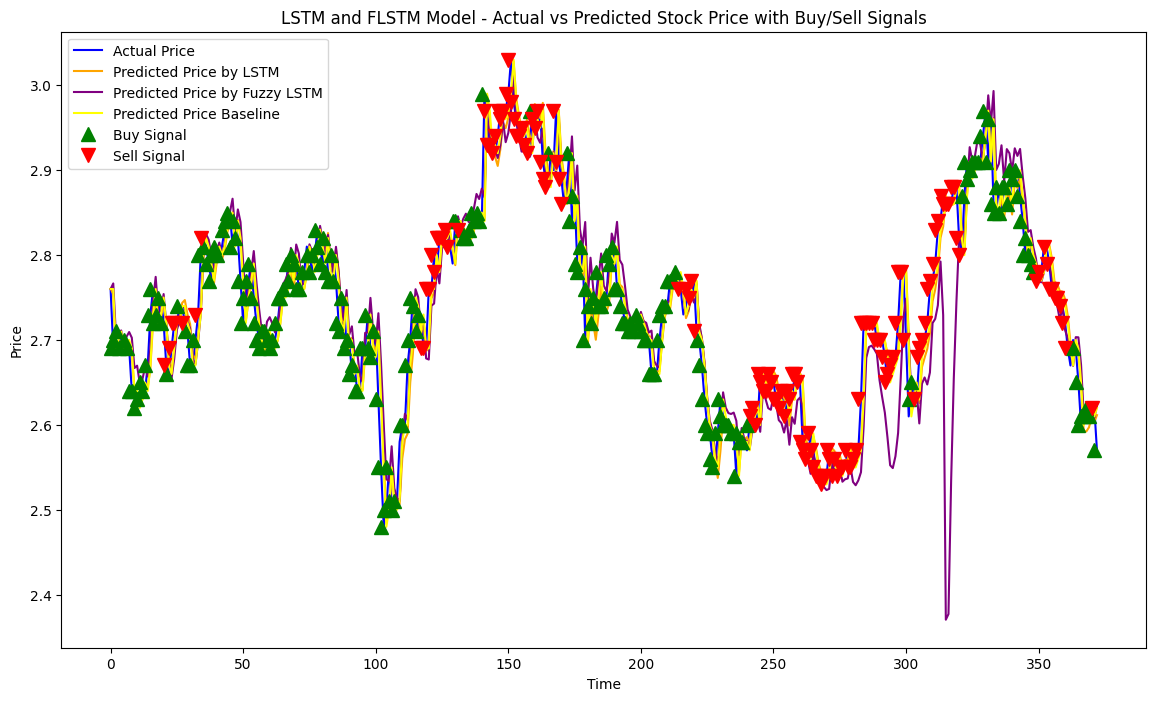

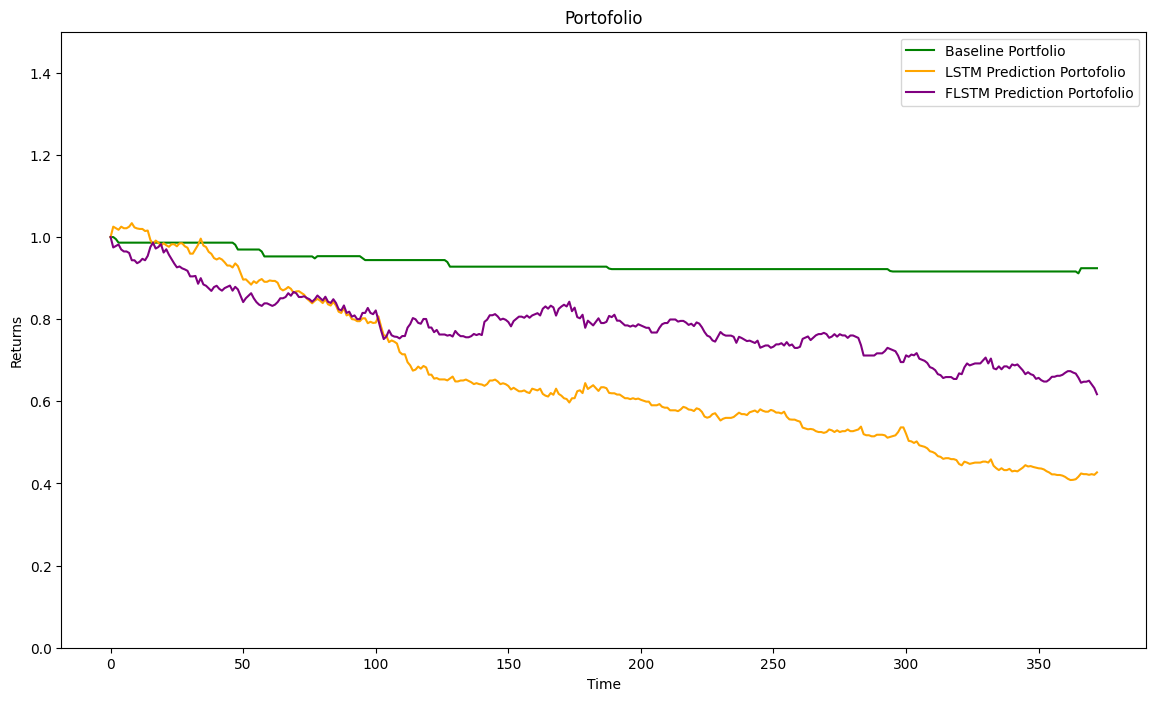

Final portofolio for baseline:  0.9241401617808742
Final portofolio for FLSTM prediction:  0.6172530677520855
Final portofolio for LSTM prediction:  0.42691686793209493


In [ ]:
# Plot actual vs predicted price with buy/sell signals
plt.figure(figsize=(14, 8))
plt.plot(y_test_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_rescaled_LSTM, label='Predicted Price by LSTM', color='orange')
plt.plot(y_pred_rescaled_FLSTM, label='Predicted Price by Fuzzy LSTM', color='purple')
plt.plot(y_pred_baseline, label='Predicted Price Baseline', color='yellow')

plt.plot(FLSTM_pred_buy_signals, marker='^', markersize=10, color='green', linestyle='None', label='Buy Signal')
plt.plot(FLSTM_pred_sell_signals, marker='v', markersize=10, color='red', linestyle='None', label='Sell Signal')
plt.title('LSTM and FLSTM Model - Actual vs Predicted Stock Price with Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot actual vs predicted price with buy/sell signals
plt.figure(figsize=(14, 8))
plt.ylim((0, 1.5))
plt.plot(baseline_portfolio, label='Baseline Portfolio', color='green')
plt.plot(LSTM_pred_portfolio, label='LSTM Prediction Portofolio', color='orange')
plt.plot(FLSTM_pred_portfolio, label='FLSTM Prediction Portofolio', color='purple')
plt.title('Portofolio')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

print("Final portofolio for baseline: ", baseline_portfolio[-1])

print("Final portofolio for FLSTM prediction: ", FLSTM_pred_portfolio[-1])
print("Final portofolio for LSTM prediction: ", LSTM_pred_portfolio[-1])